# Chapter 5: Compare NOAA/NSIDC SIC CDR to Other SIC Data

## Learning Objectives
Calculate the sea ice extent (SIE) for another sea ice concentration product from [EUMETSAT Ocean and Sea Ice Satellite Application Facility](https://osi-saf.eumetsat.int/products/osi-450-a) (OSI-SAF) and compare it to the calculation of the sea ice extent from the NOAA/NSIDC SIC CDR data (see Notebook 4). The OSI-SAF SIC data are processed with a different SIC algorithm than the NOAA/NSIDC SIC CDR. It can be instrucitve to compare different algorithms to see how the extent calculations can differ but that the overall trend in Arctic sea ice decline is still similar.

### Import relevant packages

In [1]:
import xarray as xr
import numpy as np
import numpy.ma as ma
import pandas as pd
import packaging
import aiohttp
import fsspec
import pystac
import netCDF4
from netCDF4 import Dataset
import h5netcdf
from datetime import datetime, timedelta, date
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter

### Open and read the OSI-SAF SIC data

In [2]:
# Read in OSI-SAF SIC in EPSG 6391 projection (EASE2)
osisaf_sic_fn = 'data_files/osi-saf-sic-nh-2023.nc'
osisaf_sic_nc = Dataset(osisaf_sic_fn, 'r')
print(osisaf_sic_nc.variables.keys())
print(osisaf_sic_nc.variables['ice_conc'])

dict_keys(['Lambert_Azimuthal_Grid', 'time', 'time_bnds', 'xc', 'yc', 'lat', 'lon', 'ice_conc', 'raw_ice_conc_values', 'total_standard_uncertainty', 'smearing_standard_uncertainty', 'algorithm_standard_uncertainty', 'status_flag'])
<class 'netCDF4._netCDF4.Variable'>
int32 ice_conc(time, yc, xc)
    _FillValue: -32767
    long_name: fully filtered concentration of sea ice using atmospheric correction of brightness temperatures and open water filters
    standard_name: sea_ice_area_fraction
    units: %
    valid_min: 0
    valid_max: 10000
    grid_mapping: Lambert_Azimuthal_Grid
    coordinates: lat lon
    scale_factor: 0.01
    comment: this field is the primary sea ice concentration estimate for this climate data record
    ancillary_variables: total_standard_uncertainty status_flag
    cell_methods: time: mean
unlimited dimensions: time
current shape = (365, 432, 432)
filling on


In [3]:
# Pull out sea ice concentration variable into numpy array
osisaf_seaice_conc_var = osisaf_sic_nc.variables['ice_conc']
osisaf_seaice_conc = np.array(osisaf_seaice_conc_var)
osisaf_seaice_conc.max()

np.float64(100.0)

In [4]:
osisaf_time = osisaf_sic_nc.variables['time']
osisaf_time_np = np.array(osisaf_time)
print(osisaf_time)
print(osisaf_time_np[0])
delta = timedelta(seconds=int(osisaf_time_np[0]))
human_date = date(1978,1,1) + delta
year=datetime.strftime(human_date, '%Y')
year

<class 'netCDF4._netCDF4.Variable'>
float64 time(time)
    units: seconds since 1978-01-01 00:00:00
    long_name: reference time of product
    standard_name: time
    axis: T
    calendar: standard
    bounds: time_bnds
    cell_methods: time: mean
unlimited dimensions: time
current shape = (365,)
filling on, default _FillValue of 9.969209968386869e+36 used
1420113600.0


'2023'

In [12]:
d = []
# Get daily extent and save dataframe
for t in range(len(osisaf_seaice_conc)):
    # Here we are squeezing to be 2d for each day
    osisaf_seaice_conc_2d = np.copy(osisaf_seaice_conc[t,:,:].squeeze())
    # Round to the nearest percent
    osisaf_seaice_conc_2d = np.round(osisaf_seaice_conc_2d, 1)

    # Compute Extent
    # Create mask to filter out the flag values from the computation and concentrations less than 15%
    # Fill value is -32767
    # This line removes fill values and concentration < 15%
    flag_mask_extent = ma.masked_outside(osisaf_seaice_conc_2d, 15, 100)

    # Now set all the places that aren't masked, which is sea ice concentration of 15% to 100% inclusive, to 1 because extent implies 100% concentration
    # Then muliply each grid cell by the grid cell area. Since the EASE-Grid 2 projection is an equal area projection, this is simply 25 km x 25 km for 
    # each grid cell or 625 sq km
    non_mask_extent = ma.nonzero(flag_mask_extent)
    flag_mask_extent[non_mask_extent] = 1.0 
    osisaf_sie_raster = flag_mask_extent * 625
    osisaf_sie_total = osisaf_sie_raster.sum()
    doy = t + 1 
    date = datetime.strptime(f'{year} {doy}', '%Y %j') #.strftime('%Y-%m-%d')
    # print(date, ':', cdr_seaice_exent_total)
    d.append(
        {
            'yyyy-mm-dd': date, 
            'OSISAF Extent (km2)': osisaf_sie_total
        }
    )

# Create data frame from list
osisaf_extent_df = pd.DataFrame(d)
# Set display options for pandas
pd.options.display.float_format = '{:20,.2f}'.format
# Show dataframe
osisaf_extent_df.head()

,yyyy-mm-dd,OSISAF Extent (km2)
0,2023-01-01,"12,919,375.00"
1,2023-01-02,"12,950,625.00"
2,2023-01-03,"13,018,750.00"
3,2023-01-04,"13,090,000.00"
4,2023-01-05,"13,127,500.00"


## Open the CSV file that contains the CDR sea ice extent created in Notebook 4

In [11]:
# Read in CDR csv file, set date to datetime format, and rename columns so there are no spaces in the names
cdr_fn = 'data_files/cdr_sie_2023.csv'
cdr_extent_df = pd.read_csv(cdr_fn,parse_dates=True)
cdr_extent_df['Date (yyyy/mm/dd)'] = pd.to_datetime(cdr_extent_df['Date (yyyy/mm/dd)'])
cdr_extent_df = cdr_extent_df.rename(columns={'Date (yyyy/mm/dd)': 'yyyy-mm-dd', 'Extent (km2)': 'cdr_extent'})
# Show dataframe
cdr_extent_df.head()

,yyyy-mm-dd,cdr_extent
0,2023-01-01,"12,706,378.75"
1,2023-01-02,"12,818,631.23"
2,2023-01-03,"12,862,791.12"
3,2023-01-04,"12,899,025.24"
4,2023-01-05,"12,988,706.01"


## Merge the two dataframes by date

In [10]:
# Merge dataframes by date
merged_df = pd.merge(osisaf_extent_df, cdr_extent_df, how='inner', on = 'yyyy-mm-dd')
# Rename columns so there are no spaces
merged_df = merged_df.rename(columns={'OSISAF Extent (km2)': 'osisaf_extent'})
# Show dataframe
merged_df.head()

,yyyy-mm-dd,osisaf_extent,cdr_extent
0,2023-01-01,"12,919,375.00","12,706,378.75"
1,2023-01-02,"12,950,625.00","12,818,631.23"
2,2023-01-03,"13,018,750.00","12,862,791.12"
3,2023-01-04,"13,090,000.00","12,899,025.24"
4,2023-01-05,"13,127,500.00","12,988,706.01"


## Plot the two data sets together to compare
This exercise highlights how different processing of similar data can lead to slightly different output. Note that the OSISAF sea ice extent is consistently slightly higher than the CDR SIE. Neither data product is wrong since their curves are similar but there are reasons for the differences.
The potential reasons are:
* Different algorithm using a different combination of channels (frequencies/polarizations) that have a different sensitivity to the ice/water threshold.
* Different weather filters, which have the effect of defining the ice edge by removing some low concentration ice.
* Different land spillover filter.
* Different land mask.

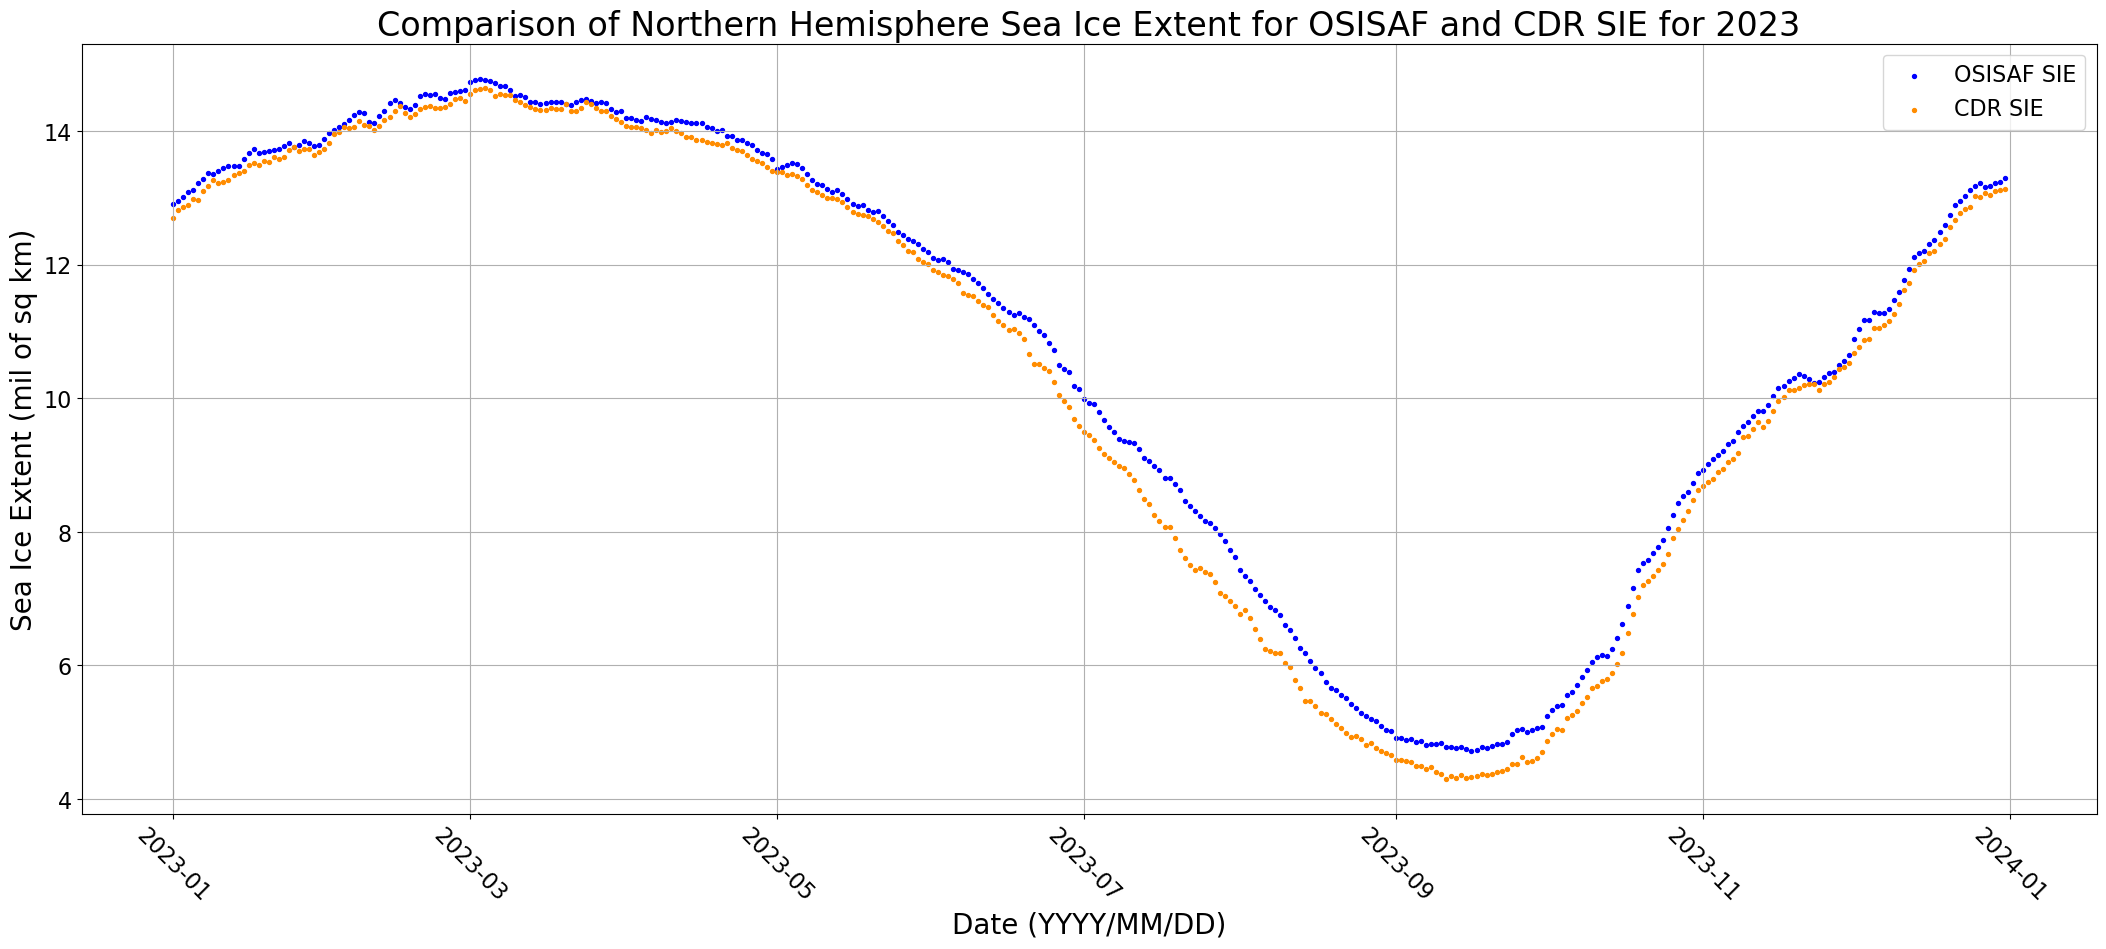

In [9]:
# Set up plot space
fig, ax1 = plt.subplots(figsize=(26, 10))

# Plot the two data sets
plt.scatter(merged_df['yyyy-mm-dd'], merged_df['osisaf_extent']/10e5, color='blue', 
            label='OSISAF SIE', s=8)
plt.scatter(merged_df['yyyy-mm-dd'], merged_df['cdr_extent']/10e5, color='darkorange', 
            label='CDR SIE', s=8)

# Set labels and ticks
plt.ylabel("Sea Ice Extent (mil of sq km)", fontsize=20)
plt.title("Comparison of Northern Hemisphere Sea Ice Extent for OSISAF and CDR SIE for 2023", fontsize=24)
plt.xlabel("Date (YYYY/MM/DD)", fontsize=20)
plt.ylabel("Sea Ice Extent (mil of sq km)", fontsize=20)
plt.xticks(rotation=-45, fontsize=16)
plt.yticks(fontsize=16)
plt.legend(fontsize=16)
plt.grid()